In [242]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
from matplotlib import pyplot as plt

import torchsummary
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [243]:
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# args = parser.parse_args()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch



In [244]:
# Data with general augmentation
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [245]:
# define augmentation strategies

def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 25.0
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

group_a=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

group_b=transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

group_c=transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), 
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

group_d=transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3), 
    transforms.ToTensor(),
    gauss_noise_tensor,
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

group_e=transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_names=['A', 'B', 'C', 'D', 'E']
test_groups=[group_a, group_b, group_c, group_d, group_e]

In [246]:
# prepare data

def prepareData(group_i):
  T=test_groups[group_i]
  trainset=torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=T)
  testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_groups[0])
  
  #trainset=torch.utils.data.Subset(trainset, range(int(len(trainset)/40)))
  #testset=torch.utils.data.Subset(testset, range(int(len(testset)/20)))
  
  trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=4)
  testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=4)
  return trainloader, testloader

In [247]:
class cSE(nn.Module):
    def __init__(self, channel, reduction=16):
        super(cSE, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class sSE(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.Conv1x1 = nn.Conv2d(in_channels, 1, kernel_size=1, bias=False)
        self.norm = nn.Sigmoid()

    def forward(self, U):
        q = self.Conv1x1(U) # U:[bs,c,h,w] to q:[bs,1,h,w]
        q = self.norm(q)
        return U * q # 广播机制

class scSE(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.cSE = cSE(in_channels)
        self.sSE = sSE(in_channels)

    def forward(self, U):
        U_sse = self.sSE(U)
        U_cse = self.cSE(U)
        return U_cse+U_sse

class SE(nn.Module):
    '''Squeeze-and-Excitation block.'''

    def __init__(self, in_planes, se_planes):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_planes, se_planes, kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_planes, in_planes, kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = F.relu(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out
        return out



class Block(nn.Module):
    def __init__(self, w_in, w_out, stride, group_width, bottleneck_ratio, se_ratio):
        super(Block, self).__init__()
        # 1x1
        w_b = int(round(w_out * bottleneck_ratio))
        self.conv1 = nn.Conv2d(w_in, w_b, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(w_b)
        # 3x3
        num_groups = w_b // group_width
        self.conv2 = nn.Conv2d(w_b, w_b, kernel_size=3,
                               stride=stride, padding=1, groups=num_groups, bias=False)
        self.bn2 = nn.BatchNorm2d(w_b)
        # se
        self.with_se = se_ratio > 0
        if self.with_se:
            w_se = int(round(w_in * se_ratio))
            self.se = SE(w_b, w_se)
        # 1x1
        self.conv3 = nn.Conv2d(w_b, w_out, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(w_out)
        self.scSE = scSE(w_out)
        self.shortcut = nn.Sequential()
        if stride != 1 or w_in != w_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(w_in, w_out,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(w_out)
            )

    def forward(self, x):
        # out = F.relu(self.scSE(self.bn1(self.conv1(x))))
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        if self.with_se:
            out = self.se(out)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        # out = F.relu(out)
        out = F.relu(self.scSE(out))
        return out


class RegNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(RegNet, self).__init__()
        self.cfg = cfg
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(0)
        self.layer2 = self._make_layer(1)
        self.layer3 = self._make_layer(2)
        self.layer4 = self._make_layer(3)
        self.linear = nn.Linear(self.cfg['widths'][-1], num_classes)

    def _make_layer(self, idx):
        depth = self.cfg['depths'][idx]
        width = self.cfg['widths'][idx]
        stride = self.cfg['strides'][idx]
        group_width = self.cfg['group_width']
        bottleneck_ratio = self.cfg['bottleneck_ratio']
        se_ratio = self.cfg['se_ratio']

        layers = []
        for i in range(depth):
            s = stride if i == 0 else 1
            layers.append(Block(self.in_planes, width,
                                s, group_width, bottleneck_ratio, se_ratio))
            self.in_planes = width
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [248]:
# # 400M
# cfg = {
#     'depths': [1, 4, 8, 12],
#     'widths': [32, 64, 160, 416],
#     'strides': [1, 1, 2, 2],
#     'group_width': 16,
#     'bottleneck_ratio': 0.5,
#     'se_ratio': 0.25,
#     'lr': 0.1,
#     'resume': False
#     }

# # 200M
# cfg = {
#         'depths': [1, 1, 4, 7],
#         'widths': [24, 56, 152, 368],
#         'strides': [1, 1, 2, 2],
#         'group_width': 8,
#         'bottleneck_ratio': 1,
#         'se_ratio': 0.25,
#         'lr': 0.1,
#         'resume': False,
#         'T_0': 200,
#         'T_mul': 3,
#         'eta_min':0
#     }

# # 200M without se
# cfg = {
#         'depths': [1, 1, 4, 7],
#         'widths': [24, 56, 152, 368],
#         'strides': [1, 1, 2, 2],
#         'group_width': 8,
#         'bottleneck_ratio': 1,
#         'se_ratio': 0,
#         'lr': 0.1,
#         'resume': False,
#         'T_0': 200,
#         'T_mul': 3,
#         'eta_min':0
#     }

# 500M
cfg = {
        'depths': [1, 2, 5, 11],
        'widths': [32, 64, 160, 368],
        'strides': [1, 1, 2, 2],
        'group_width': 16,
        'bottleneck_ratio': 1,
        'se_ratio': 0.25,
        'lr': 0.1,
        'resume': False
    }

In [249]:
# Specify the net
net = RegNet(cfg)
net = net.to(device)
torchsummary.summary(net,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 32, 32, 32]           2,048
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7             [-1, 16, 1, 1]             528
            Conv2d-8             [-1, 32, 1, 1]             544
                SE-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           1,024
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]           2,048
      BatchNorm2d-13           [-1, 32, 32, 32]              64
           Conv2d-14            [-1, 1,

In [250]:
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if cfg['resume']:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=args.lr, betas=(0.9, 0.999),
#                        eps=1e-08,weight_decay=0,amsgrad=False)       
optimizer = optim.SGD(net.parameters(), lr=cfg['lr'],
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = cfg['T_0'], T_mult=cfg['T_mul'], eta_min = cfg['eta_min'], last_epoch = -1, verbose = False)

In [251]:
# Training
def train(epoch):

    # print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    train_loss = train_loss / len(trainloader)
    train_acc = 100.*correct / total

    return train_loss, train_acc

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        test_loss = test_loss / len(testloader)
        test_acc = 100.*correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

    return test_loss, test_acc

In [252]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_loss_history = []
test_loss_history = []

EPOCHS = 200
for epoch in range(start_epoch, EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    scheduler.step()
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc:.2f} | Best Acc:{best_acc:.2f}%')

In [ ]:
# Train with auto augmentation

# start_epoch = 0
# EPOCHS = 80
# avg_best_accs=[]
# train_loss_history = []
# test_loss_history = []
# test_acc_history = []

# trainloader, testloader = prepareData(-1)
# print('======= start test group:', test_groups[-1], '=======')
# for epoch in range(start_epoch, EPOCHS):
#     start_time = time.monotonic()

#     train_loss, train_acc = train(epoch)
#     test_loss, test_acc = test(epoch)
#     train_loss_history.append(train_loss)
#     test_loss_history.append(test_loss)
#     test_acc_history.append(test_acc)

#     end_time = time.monotonic()
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
#     scheduler.step()
#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}')
#     print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc:.2f} | Best Acc:{best_acc:.2f}%')
# test_acc_history.sort(reverse=True)
# avg_best_accs.append(sum(test_acc_history[:5])/5.00)

In [ ]:
filename = './output/lr/ba=94.95-se-lr=0.1-t0=200-bs=256.txt'
output = open(filename,'w',encoding = 'gbk')
for i in range(len(train_loss_history)):
    rowtxt = '{},{}'.format(train_loss_history[i],test_loss_history[i])
    output.write(rowtxt)
    output.write('\n')
output.close()

In [240]:
# Load the best acc result

checkpoint = torch.load('./checkpoint/ba=94.95-500M.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']
test_loss, test_acc = test(1)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f} | best_acc:{best_acc:.2f}%')

# checkpoint = torch.load('./checkpoint/ba=95.33-200M-seRatio=0.pth')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# print(best_acc)
# start_epoch = checkpoint['epoch']

# test_loss, test_acc = test(1)
# print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f} | best_acc:{best_acc:.2f}%')

Test Loss: 0.209 | Test Acc: 94.95 | best_acc:94.95%


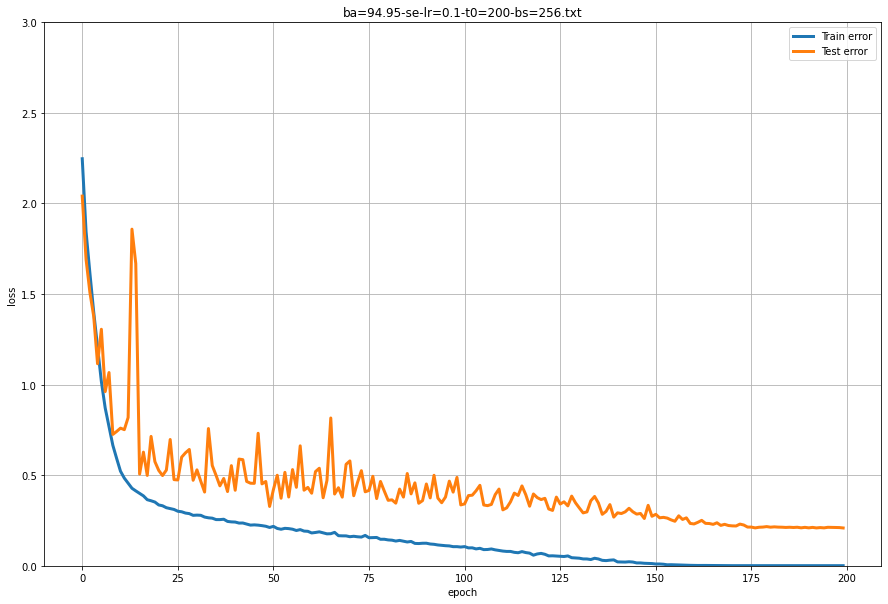

In [219]:
# Draw the loss curve of training and testing data
plt.figure(figsize=(15,10))
plt.plot(range(len(train_loss_history)), train_loss_history,'-', linewidth=3, label = 'Train error')
plt.plot(range(len(test_loss_history)), test_loss_history, '-', linewidth=3, label = 'Test error')
plt.ylim(0,3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('ba=94.95-se-lr=0.1-t0=200-bs=256.txt')
plt.grid(True)
plt.legend()

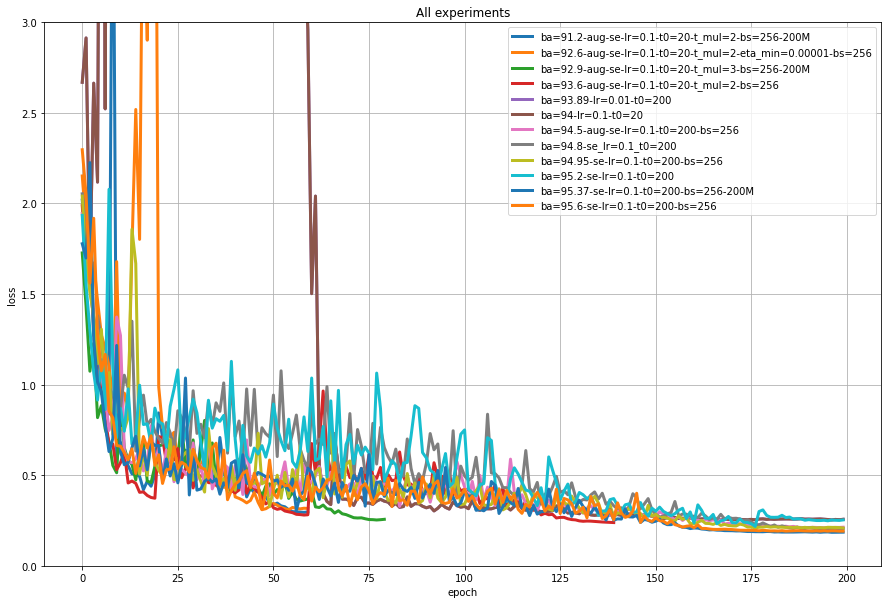

In [220]:
# Draw loss curve from all experiments

from pathlib import Path
import os
file_list = []
filename_list = []
output_dec = Path("./output/lr")
file_dir = os.listdir(output_dec)
for file in file_dir:
    if file.endswith('.txt'):
        filename = file[:-4]
        filename_list.append(filename)
        filePath = os.path.join(output_dec,file)
        file_list.append(filePath)
# print("file_list:", file_list)
# print("filename_list:",filename_list)
# filename1 = './output/lr/se_ba=95.6_lr=0.1_t0=200_bs=256.txt'
# file = filename1.split("/")[-1][:-4]

train_loss_list, test_loss_list = [],[]
for file in file_list:
    train_temp, test_temp = [],[]
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            value = [float(s) for s in line.split(",")]
            train_temp.append(value[0])
            test_temp.append(value[1])
    train_loss_list.append(train_temp)
    test_loss_list.append(test_temp)    


plt.figure(figsize=(15,10))
for i in range(len(filename_list)):
    plt.plot(range(len(train_loss_list[i])), test_loss_list[i], '-', linewidth=3, label = filename_list[i])
plt.ylim(0,3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('All experiments')
plt.grid(True)
plt.legend()